In [0]:
%run ./00_setup_and_config


In [0]:
%run ./03_strategy_implementations


In [0]:
%run ./04_backtesting_engine

COMMODITY CONFIGURATIONS

COFFEE:
  Harvest volume: 50 tons/year
  Harvest windows: [(5, 9)]
  Total harvest weeks: 21
  Weekly harvest rate: 2.38 tons/week

  Costs (percentage-based):
    Storage: 0.025% of value per day
    Transaction: 0.25% of sale value
    Max holding: 365 days from harvest start

  Example at $150/ton:
    Transaction cost (full harvest): $18.75
    Storage per day (full harvest): $1.88
    Storage per month (full harvest): $56.25
    Storage for 6 months: $337.50

Real Prediction Data:
  ✓ Real prediction data found in table: commodity.forecast.distributions
  Model versions available: 12
    - arima_111_v1
    - arima_v1
    - naive
    - naive_baseline
    - prophet_v1
    - random_walk_baseline
    - random_walk_v1
    - random_walk_v1_test
    - sarimax_auto_weather_v1
    - sarimax_weather_v1
    - xgboost
    - xgboost_weather_v1

SUGAR:
  Harvest volume: 50 tons/year
  Harvest windows: [(10, 12)]
  Total harvest weeks: 12
  Weekly harvest rate: 4.17 ton

COMMODITY CONFIGURATIONS

COFFEE:
  Harvest volume: 50 tons/year
  Harvest windows: [(5, 9)]
  Total harvest weeks: 21
  Weekly harvest rate: 2.38 tons/week

  Costs (percentage-based):
    Storage: 0.025% of value per day
    Transaction: 0.25% of sale value
    Max holding: 365 days from harvest start

  Example at $150/ton:
    Transaction cost (full harvest): $18.75
    Storage per day (full harvest): $1.88
    Storage per month (full harvest): $56.25
    Storage for 6 months: $337.50

Real Prediction Data:
  ✓ Real prediction data found in table: commodity.forecast.distributions
  Model versions available: 12
    - arima_111_v1
    - arima_v1
    - naive
    - naive_baseline
    - prophet_v1
    - random_walk_baseline
    - random_walk_v1
    - random_walk_v1_test
    - sarimax_auto_weather_v1
    - sarimax_weather_v1
    - xgboost
    - xgboost_weather_v1

SUGAR:
  Harvest volume: 50 tons/year
  Harvest windows: [(10, 12)]
  Total harvest weeks: 12
  Weekly harvest rate: 4.17 ton

In [0]:
# NOTEBOOK 05: RUN COMPARATIVE ANALYSIS (UPDATED - MULTI-MODEL)
# ============================================================================
# Databricks notebook source
# MAGIC %md
# MAGIC # Run Comparative Analysis - All Commodities and Model Versions
# MAGIC 
# MAGIC Runs backtest analysis for all configured commodities and model versions sequentially.
# MAGIC Generates commodity-specific results and cross-commodity comparisons.
# MAGIC 
# MAGIC **Tests 9 Strategies:**
# MAGIC - 4 Baselines: Immediate Sale, Equal Batch, Price Threshold, Moving Average
# MAGIC - 5 Prediction-based: Consensus, Expected Value, Risk-Adjusted, Price Threshold Predictive, MA Predictive
# MAGIC 
# MAGIC **Updates:**
# MAGIC - Added multi-model support (loops over all model versions)
# MAGIC - Tracks model_version in all results
# MAGIC - Added Total Revenue (Without Costs) visualization
# MAGIC - Enhanced scenario tracking for Risk-Adjusted strategy
# MAGIC - Includes 2 NEW A/B test strategies (predictive versions of baseline strategies)
# MAGIC - All existing functionality preserved

# COMMAND ----------



# COMMAND ----------

import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.dates as mdates

# COMMAND ----------

# MAGIC %md
# MAGIC ## Run Analysis for All Commodities and Model Versions

# COMMAND ----------

# Store results for all commodities and models
all_commodity_results = {}

# Loop through each commodity
for CURRENT_COMMODITY in COMMODITY_CONFIGS.keys():
    print("\n" + "=" * 80)
    print(f"STARTING ANALYSIS FOR: {CURRENT_COMMODITY.upper()}")
    print("=" * 80)
    
    # Get commodity-specific configuration
    commodity_config = COMMODITY_CONFIGS[CURRENT_COMMODITY]
    
    # Initialize storage for this commodity
    all_commodity_results[CURRENT_COMMODITY] = {}
    
    # --------------------------------------------------------------------------
    # Discover all model versions for this commodity
    # --------------------------------------------------------------------------
    print(f"\nDiscovering model versions...")
    
    # Check synthetic predictions
    synthetic_versions = []
    try:
        DATA_PATHS = get_data_paths(CURRENT_COMMODITY)
        synthetic_df = spark.table(DATA_PATHS['predictions']).select("model_version").distinct()
        synthetic_versions = [row.model_version for row in synthetic_df.collect()]
        print(f"  Synthetic models: {synthetic_versions}")
    except Exception as e:
        print(f"  No synthetic predictions found: {e}")
    
    # Check real predictions
    real_versions = []
    try:
        real_versions = get_model_versions(CURRENT_COMMODITY)
        print(f"  Real models: {real_versions}")
    except Exception as e:
        print(f"  No real predictions found: {e}")
    
    # Combine all model versions
    all_model_versions = list(set(synthetic_versions + real_versions))
    
    if len(all_model_versions) == 0:
        print(f"\n⚠️  No model versions found for {CURRENT_COMMODITY}")
        continue
    
    print(f"\n✓ Found {len(all_model_versions)} model versions for {CURRENT_COMMODITY}")
    
    # --------------------------------------------------------------------------
    # Process each model version
    # --------------------------------------------------------------------------
    for model_idx, MODEL_VERSION in enumerate(all_model_versions, 1):
        print("\n" + "#" * 80)
        print(f"# MODEL {model_idx}/{len(all_model_versions)}: {CURRENT_COMMODITY.upper()} - {MODEL_VERSION}")
        print("#" * 80)
        
        MODEL_DATA_PATHS = get_data_paths(CURRENT_COMMODITY, MODEL_VERSION)
        
        # Determine source type
        source_type = "SYNTHETIC" if MODEL_VERSION.startswith('synthetic_') else "REAL"
        
        # ----------------------------------------------------------------------
        # Load prepared data for this model version
        # ----------------------------------------------------------------------
        print(f"\nLoading prepared data for {CURRENT_COMMODITY.upper()} - {MODEL_VERSION}...")
        
        try:
            # Load prices (same for all models of this commodity)
            prices = spark.table(get_data_paths(CURRENT_COMMODITY)['prices_prepared']).toPandas()
            prices['date'] = pd.to_datetime(prices['date'])
            
            print(f"✓ Loaded {len(prices)} days of prices")
            
            # Load prediction matrices for this model version
            # Determine path based on model version type
            if MODEL_VERSION.startswith('synthetic_'):
                matrices_path = MODEL_DATA_PATHS['prediction_matrices']
            else:
                matrices_path = MODEL_DATA_PATHS['prediction_matrices_real']
            
            with open(matrices_path, 'rb') as f:
                prediction_matrices = pickle.load(f)
            
            print(f"✓ Loaded {len(prediction_matrices)} prediction matrices ({source_type})")
            
            # Inspect prediction structure
            if len(prediction_matrices) > 0:
                sample_matrix = list(prediction_matrices.values())[0]
                print(f"✓ Prediction structure: {sample_matrix.shape[0]} runs × {sample_matrix.shape[1]} horizons")
            
        except Exception as e:
            print(f"❌ Error loading data for {MODEL_VERSION}: {e}")
            continue
        
        # ----------------------------------------------------------------------
        # Date alignment diagnostic (optional - can comment out after verification)
        # ----------------------------------------------------------------------
        if False:  # Set to True to enable diagnostic
            print("\n" + "=" * 80)
            print("DATE ALIGNMENT DIAGNOSTIC")
            print("=" * 80)
            
            pred_keys = list(prediction_matrices.keys())
            price_dates = prices['date'].tolist()
            pred_set = set(pred_keys)
            price_set = set(price_dates)
            overlap = pred_set.intersection(price_set)
            
            print(f"\nOverlap Analysis:")
            print(f"  Total prediction keys: {len(pred_set)}")
            print(f"  Total price dates: {len(price_set)}")
            print(f"  Matching dates: {len(overlap)}")
            print(f"  Match rate: {100*len(overlap)/len(pred_set) if len(pred_set) > 0 else 0:.1f}%")
            
            if len(overlap) == 0:
                print("\n❌ WARNING: NO MATCHING DATES!")
            else:
                print("\n✓ SUCCESS: Dates are aligned!")
            
            print("=" * 80)
        
        # ----------------------------------------------------------------------
        # Initialize strategies
        # ----------------------------------------------------------------------
        print(f"\nInitializing strategies...")
        
        baselines = [
            ImmediateSaleStrategy(),
            EqualBatchStrategy(**BASELINE_PARAMS['equal_batch']),
            PriceThresholdStrategy(
                threshold_pct=BASELINE_PARAMS['price_threshold']['threshold_pct']
            ),
            MovingAverageStrategy(
                ma_period=BASELINE_PARAMS['moving_average']['ma_period']
            )
        ]
        
        prediction_strategies = [
            ConsensusStrategy(**PREDICTION_PARAMS['consensus']),
            ExpectedValueStrategy(
                storage_cost_pct_per_day=commodity_config['storage_cost_pct_per_day'],
                transaction_cost_pct=commodity_config['transaction_cost_pct'],
                **PREDICTION_PARAMS['expected_value']
            ),
            RiskAdjustedStrategy(**PREDICTION_PARAMS['risk_adjusted']),
            # NEW A/B Test Strategies
            PriceThresholdPredictive(
                threshold_pct=BASELINE_PARAMS['price_threshold']['threshold_pct'],
                batch_fraction=0.25,
                max_days_without_sale=60
            ),
            MovingAveragePredictive(
                ma_period=BASELINE_PARAMS['moving_average']['ma_period'],
                batch_fraction=0.25,
                max_days_without_sale=60
            )
        ]
        
        all_strategies = baselines + prediction_strategies
        
        print(f"✓ {len(baselines)} baseline strategies")
        print(f"✓ {len(prediction_strategies)} prediction-based strategies (3 enhanced + 2 A/B test)")
        print(f"Total: {len(all_strategies)} strategies to test")
        
        # ----------------------------------------------------------------------
        # Run backtests
        # ----------------------------------------------------------------------
        print("\n" + "=" * 80)
        print(f"RUNNING BACKTESTS - {CURRENT_COMMODITY.upper()} - {MODEL_VERSION}")
        print("=" * 80)
        
        engine = BacktestEngine(prices, prediction_matrices, commodity_config)
        
        results_dict = {}
        metrics_list = []
        
        for i, strategy in enumerate(all_strategies, 1):
            print(f"\n[{i}/{len(all_strategies)}] Running: {strategy.name}...")
            results = engine.run(strategy)
            metrics = calculate_metrics(results)
            results_dict[strategy.name] = results
            metrics_list.append(metrics)
            
            print(f"  Total Revenue:  ${metrics['total_revenue']:,.2f}")
            print(f"  Net Earnings:   ${metrics['net_earnings']:,.2f}")
            print(f"  Avg Sale Price: ${metrics['avg_sale_price']:.2f}")
            print(f"  Total Costs:    ${metrics['total_costs']:,.2f}") 
            print(f"  Trades:         {metrics['n_trades']}")
        
        print("\n" + "=" * 80)
        print("BACKTESTS COMPLETE")
        print("=" * 80)
        
        # ----------------------------------------------------------------------
        # Analyze Risk-Adjusted Strategy Scenarios
        # ----------------------------------------------------------------------
        print("\nAnalyzing Risk-Adjusted Strategy Scenarios...")
        
        if 'Risk-Adjusted' in results_dict:
            risk_adj_results = results_dict['Risk-Adjusted']
            trades = risk_adj_results['trades']
            
            # DEBUG: Print actual trade reasons
            print("\nDEBUG - All Risk-Adjusted Trade Reasons:")
            reason_counts = {}
            for trade in trades:
                reason = trade.get('reason', 'UNKNOWN')
                reason_counts[reason] = reason_counts.get(reason, 0) + 1
            
            for reason, count in sorted(reason_counts.items(), key=lambda x: x[1], reverse=True):
                print(f"  {count:2d}× {reason}")
            print()
            
            # Extract scenario counts from trade reasons
            scenario_counts = {
                'very_low_risk_8pct': 0,
                'low_risk_12pct': 0,
                'medium_risk_18pct': 0,
                'med_high_risk_25pct': 0,
                'high_risk_30pct': 0,
                'very_high_risk_40pct': 0,
                'other': 0
            }
            
            for trade in trades:
                reason = trade.get('reason', '')
                if 'very_low_risk' in reason or ('cv' in reason and 'defer' in reason):
                    scenario_counts['very_low_risk_8pct'] += 1
                elif 'low_risk' in reason and 'ret' in reason:
                    scenario_counts['low_risk_12pct'] += 1
                elif 'medium_risk' in reason and 'baseline' in reason:
                    scenario_counts['medium_risk_18pct'] += 1
                elif 'med_high_risk' in reason or 'weak_trend' in reason:
                    scenario_counts['med_high_risk_25pct'] += 1
                elif 'high_risk' in reason and 'reduce_exposure' in reason:
                    scenario_counts['high_risk_30pct'] += 1
                elif 'very_high_risk' in reason or 'exit_fast' in reason:
                    scenario_counts['very_high_risk_40pct'] += 1
                else:
                    scenario_counts['other'] += 1
            
            print("Risk-Adjusted Strategy - Scenario Distribution:")
            print(f"  Very Low Risk (8% batch):       {scenario_counts['very_low_risk_8pct']} trades")
            print(f"  Low Risk (12% batch):           {scenario_counts['low_risk_12pct']} trades")
            print(f"  Medium Risk (18% batch):        {scenario_counts['medium_risk_18pct']} trades")
            print(f"  Med-High Risk (25% batch):      {scenario_counts['med_high_risk_25pct']} trades")
            print(f"  High Risk (30% batch):          {scenario_counts['high_risk_30pct']} trades")
            print(f"  Very High Risk (40% batch):     {scenario_counts['very_high_risk_40pct']} trades")
            print(f"  Other (deadline/fallback):      {scenario_counts['other']} trades")
        
        # ----------------------------------------------------------------------
        # Create results table
        # ----------------------------------------------------------------------
        results_df = pd.DataFrame(metrics_list)
        baseline_names = [s.name for s in baselines]
        results_df['type'] = results_df['strategy'].apply(
            lambda x: 'Baseline' if x in baseline_names else 'Prediction'
        )
        results_df['commodity'] = CURRENT_COMMODITY
        results_df['model_version'] = MODEL_VERSION
        
        # Sort by net earnings
        results_df = results_df.sort_values('net_earnings', ascending=False)
        
        # ----------------------------------------------------------------------
        # Identify best performers
        # ----------------------------------------------------------------------
        best_baseline = results_df[results_df['type'] == 'Baseline'].iloc[0]
        best_prediction = results_df[results_df['type'] == 'Prediction'].iloc[0]
        best_overall = results_df.iloc[0]
        
        # Calculate advantage
        earnings_diff = best_prediction['net_earnings'] - best_baseline['net_earnings']
        pct_diff = (earnings_diff / abs(best_baseline['net_earnings'])) * 100 if best_baseline['net_earnings'] != 0 else 0
        
        print("\n" + "=" * 80)
        print(f"RESULTS SUMMARY - {CURRENT_COMMODITY.upper()} - {MODEL_VERSION}")
        print("=" * 80)
        print(f"\n🏆 Best Overall: {best_overall['strategy']}")
        print(f"   Net Earnings: ${best_overall['net_earnings']:,.2f}")
        print(f"\n📊 Best Baseline: {best_baseline['strategy']}")
        print(f"   Net Earnings: ${best_baseline['net_earnings']:,.2f}")
        print(f"\n🎯 Best Prediction: {best_prediction['strategy']}")
        print(f"   Net Earnings: ${best_prediction['net_earnings']:,.2f}")
        print(f"\n📈 Prediction Advantage: ${earnings_diff:+,.2f} ({pct_diff:+.1f}%)")
        
        # ----------------------------------------------------------------------
        # Save results
        # ----------------------------------------------------------------------
        print("\nSaving results...")
        
        # Save to Delta
        spark.createDataFrame(results_df).write.format("delta").mode("overwrite") \
            .saveAsTable(MODEL_DATA_PATHS['results'])
        print(f"  ✓ Saved to Delta: {MODEL_DATA_PATHS['results']}")
        
        # Save detailed results
        with open(MODEL_DATA_PATHS['results_detailed'], 'wb') as f:
            pickle.dump(results_dict, f)
        print(f"  ✓ Saved: {MODEL_DATA_PATHS['results_detailed']}")
        
        # ----------------------------------------------------------------------
        # Generate visualizations
        # ----------------------------------------------------------------------
        print("\nGenerating visualizations...")
        
        # Net earnings chart
        fig, ax = plt.subplots(figsize=(14, 8))
        baseline_data = results_df[results_df['type'] == 'Baseline'].sort_values('net_earnings', ascending=True)
        prediction_data = results_df[results_df['type'] == 'Prediction'].sort_values('net_earnings', ascending=True)
        
        y_baseline = range(len(baseline_data))
        y_prediction = range(len(baseline_data), len(baseline_data) + len(prediction_data))
        
        ax.barh(y_baseline, baseline_data['net_earnings'], color='steelblue', alpha=0.7, label='Baseline')
        ax.barh(y_prediction, prediction_data['net_earnings'], color='orangered', alpha=0.7, label='Prediction')
        
        all_strategies_sorted = pd.concat([baseline_data, prediction_data])
        ax.set_yticks(range(len(all_strategies_sorted)))
        ax.set_yticklabels(all_strategies_sorted['strategy'])
        ax.set_xlabel('Net Earnings ($)', fontsize=12)
        ax.set_title(f'Net Earnings by Strategy - {CURRENT_COMMODITY.upper()} - {MODEL_VERSION}', 
                     fontsize=14, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3, axis='x')
        
        for i, (idx, row) in enumerate(all_strategies_sorted.iterrows()):
            ax.text(row['net_earnings'], i, f"  ${row['net_earnings']:,.0f}", va='center', fontsize=9)
        
        plt.tight_layout()
        earnings_chart_path = f"{VOLUME_PATH}/net_earnings_{CURRENT_COMMODITY}_{MODEL_VERSION}.png"
        plt.savefig(earnings_chart_path, dpi=300, bbox_inches='tight')
        print(f"  ✓ Saved: {earnings_chart_path}")
        plt.show()
        plt.close()
        
        # ----------------------------------------------------------------------
        # Generate Trading Timeline Visualization
        # ----------------------------------------------------------------------
        print("\nGenerating trading timeline visualization...")
        
        fig, ax = plt.subplots(figsize=(16, 8))
        
        # Plot price history as background
        ax.plot(prices['date'], prices['price'], color='gray', linewidth=1.5,
                alpha=0.5, label='Price History', zorder=1)
        
        # Color map for strategies
        colors = plt.cm.tab10(np.linspace(0, 1, len(all_strategies)))
        strategy_colors = dict(zip([s.name for s in all_strategies], colors))
        
        # Plot trades for each strategy
        for name, results in results_dict.items():
            trades = results['trades']
            if len(trades) > 0:
                trade_dates = [t['date'] for t in trades]
                trade_prices = [t['price'] for t in trades]
                trade_amounts = [t['amount'] for t in trades]
                
                # Marker size proportional to trade amount
                sizes = [amt * 10 for amt in trade_amounts]
                
                ax.scatter(trade_dates, trade_prices, s=sizes, alpha=0.6,
                          color=strategy_colors[name], label=name,
                          edgecolors='black', linewidth=0.5, zorder=2)
        
        ax.set_xlabel('Date', fontsize=12)
        ax.set_ylabel('Price ($/ton)', fontsize=12)
        ax.set_title(f'Trading Timeline - {CURRENT_COMMODITY.upper()} - {MODEL_VERSION}', 
                     fontsize=14, fontweight='bold')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        timeline_path = f"{VOLUME_PATH}/trading_timeline_{CURRENT_COMMODITY}_{MODEL_VERSION}.png"
        plt.savefig(timeline_path, dpi=300, bbox_inches='tight')
        print(f"  ✓ Saved: {timeline_path}")
        plt.show()
        plt.close()
        
        # ----------------------------------------------------------------------
        # Total Revenue Without Costs Visualization
        # ----------------------------------------------------------------------
        print(f"\nGenerating total revenue (without costs) chart...")
        
        fig, ax = plt.subplots(figsize=(16, 8))
        
        # Calculate and plot cumulative revenue for each strategy (no costs deducted)
        for name, results in results_dict.items():
            daily_state = results['daily_state']
            trades_by_day = {t['day']: t for t in results['trades']}
            
            # Build up cumulative revenue day by day
            cumulative_revenue = []
            dates = []
            running_revenue = 0
            
            for idx, row in daily_state.iterrows():
                day = row['day']
                date = row['date']
                
                # Add any sales revenue from today (no costs subtracted)
                if day in trades_by_day:
                    trade = trades_by_day[day]
                    running_revenue += trade['revenue']
                
                cumulative_revenue.append(running_revenue)
                dates.append(date)
            
            # Plot full time series
            is_pred = name not in [s.name for s in baselines]
            ax.plot(dates, cumulative_revenue, label=name,
                   linestyle='-' if is_pred else '--',
                   linewidth=2 if is_pred else 1.5,
                   alpha=0.9 if is_pred else 0.6)
        
        ax.set_xlabel('Date', fontsize=12)
        ax.set_ylabel('Cumulative Total Revenue ($)', fontsize=12)
        ax.set_title(f'Cumulative Total Revenue Over Time (Without Costs) - {CURRENT_COMMODITY.upper()} - {MODEL_VERSION}',
                     fontsize=14, fontweight='bold')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
        ax.grid(True, alpha=0.3)
        ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
        
        # Format x-axis to show dates nicely
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
        
        plt.tight_layout()
        
        revenue_only_path = f'{VOLUME_PATH}/total_revenue_no_costs_{CURRENT_COMMODITY}_{MODEL_VERSION}.png'
        plt.savefig(revenue_only_path, dpi=300, bbox_inches='tight')
        print(f"  ✓ Saved: {revenue_only_path}")
        plt.show()
        plt.close()
        
        # ----------------------------------------------------------------------
        # Cumulative Net Revenue Visualization
        # ----------------------------------------------------------------------
        print(f"\nGenerating cumulative net revenue chart...")
        
        fig, ax = plt.subplots(figsize=(16, 8))
        
        # Calculate and plot cumulative net revenue for each strategy
        for name, results in results_dict.items():
            daily_state = results['daily_state']
            trades_by_day = {t['day']: t for t in results['trades']}
            
            # Build up cumulative values day by day
            cumulative_net_revenue = []
            dates = []
            running_revenue = 0
            running_transaction_costs = 0
            running_storage_costs = 0
            
            for idx, row in daily_state.iterrows():
                day = row['day']
                date = row['date']
                
                # Add any sales revenue/costs from today
                if day in trades_by_day:
                    trade = trades_by_day[day]
                    running_revenue += trade['revenue']
                    running_transaction_costs += trade['transaction_cost']
                
                # Add today's storage cost
                running_storage_costs += row['daily_storage_cost']
                
                # Net earnings to date
                net_revenue = running_revenue - running_transaction_costs - running_storage_costs
                cumulative_net_revenue.append(net_revenue)
                dates.append(date)
            
            # Plot full time series
            is_pred = name not in [s.name for s in baselines]
            ax.plot(dates, cumulative_net_revenue, label=name,
                   linestyle='-' if is_pred else '--',
                   linewidth=2 if is_pred else 1.5,
                   alpha=0.9 if is_pred else 0.6)
        
        ax.set_xlabel('Date', fontsize=12)
        ax.set_ylabel('Cumulative Net Revenue ($)', fontsize=12)
        ax.set_title(f'Cumulative Net Revenue Over Time - {CURRENT_COMMODITY.upper()} - {MODEL_VERSION}',
                     fontsize=14, fontweight='bold')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
        ax.grid(True, alpha=0.3)
        ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
        
        # Format x-axis
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
        
        plt.tight_layout()
        
        cumulative_path = f'{VOLUME_PATH}/cumulative_returns_{CURRENT_COMMODITY}_{MODEL_VERSION}.png'
        plt.savefig(cumulative_path, dpi=300, bbox_inches='tight')
        print(f"  ✓ Saved: {cumulative_path}")
        plt.show()
        plt.close()
        
        # ----------------------------------------------------------------------
        # Inventory Drawdown Visualization
        # ----------------------------------------------------------------------
        print(f"\nGenerating inventory drawdown chart...")
        
        fig, ax = plt.subplots(figsize=(16, 8))
        
        # Plot inventory levels over time for each strategy
        for name, results in results_dict.items():
            daily_state = results['daily_state']
            
            dates = daily_state['date'].tolist()
            inventory = daily_state['inventory'].tolist()
            
            # Plot
            is_pred = name not in [s.name for s in baselines]
            ax.plot(dates, inventory, label=name,
                   linestyle='-' if is_pred else '--',
                   linewidth=2 if is_pred else 1.5,
                   alpha=0.9 if is_pred else 0.6)
        
        ax.set_xlabel('Date', fontsize=12)
        ax.set_ylabel('Inventory (tons)', fontsize=12)
        ax.set_title(f'Inventory Drawdown Over Time - {CURRENT_COMMODITY.upper()} - {MODEL_VERSION}',
                     fontsize=14, fontweight='bold')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
        ax.grid(True, alpha=0.3)
        ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
        
        # Format x-axis
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
        
        plt.tight_layout()
        
        drawdown_path = f'{VOLUME_PATH}/inventory_drawdown_{CURRENT_COMMODITY}_{MODEL_VERSION}.png'
        plt.savefig(drawdown_path, dpi=300, bbox_inches='tight')
        print(f"  ✓ Saved: {drawdown_path}")
        plt.show()
        plt.close()
        
        # ----------------------------------------------------------------------
        # Forced Liquidation Analysis
        # ----------------------------------------------------------------------
        print(f"\nAnalyzing forced liquidations...")
        
        if 'Risk-Adjusted' in results_dict:
            forced = [t for t in results_dict['Risk-Adjusted']['trades']
                     if 'liquidate' in t['reason'].lower() or 'forced' in t['reason'].lower()]
            
            if len(forced) > 0:
                print(f"\nForced liquidation events for Risk-Adjusted strategy:")
                for t in forced:
                    print(f"  {str(t['date'])[:10]}: {t['amount']:6.2f} tons - {t['reason']}")
                
                total = sum(t['amount'] for t in forced)
                print(f"\nTotal: {total:.2f} tons across {len(forced)} events")
                print(f"Average: {total/len(forced):.2f} tons per liquidation")
                
                # Calculate % of total harvest
                total_harvest = commodity_config['harvest_volume']
                pct_liquidated = (total / total_harvest) * 100
                print(f"% of total harvest: {pct_liquidated:.1f}%")
            else:
                print("No forced liquidations detected")
        
        # ----------------------------------------------------------------------
        # Store results for cross-model/commodity comparison
        # ----------------------------------------------------------------------
        all_commodity_results[CURRENT_COMMODITY][MODEL_VERSION] = {
            'commodity': CURRENT_COMMODITY,
            'model_version': MODEL_VERSION,
            'results_df': results_df,
            'results_dict': results_dict,
            'best_baseline': best_baseline,
            'best_prediction': best_prediction,
            'best_overall': best_overall,
            'earnings_diff': earnings_diff,
            'pct_diff': pct_diff,
            'prices': prices,
            'config': commodity_config
        }
        
        print(f"\n✓ Analysis complete for {CURRENT_COMMODITY.upper()} - {MODEL_VERSION}")

print("\n" + "=" * 80)
print("ALL COMMODITY ANALYSES COMPLETE")
print("=" * 80)

# COMMAND ----------



COMMODITY CONFIGURATIONS

COFFEE:
  Harvest volume: 50 tons/year
  Harvest windows: [(5, 9)]
  Total harvest weeks: 21
  Weekly harvest rate: 2.38 tons/week

  Costs (percentage-based):
    Storage: 0.025% of value per day
    Transaction: 0.25% of sale value
    Max holding: 365 days from harvest start

  Example at $150/ton:
    Transaction cost (full harvest): $18.75
    Storage per day (full harvest): $1.88
    Storage per month (full harvest): $56.25
    Storage for 6 months: $337.50

Real Prediction Data:
  ✓ Real prediction data found in table: commodity.forecast.distributions
  Model versions available: 12
    - arima_111_v1
    - arima_v1
    - naive
    - naive_baseline
    - prophet_v1
    - random_walk_baseline
    - random_walk_v1
    - random_walk_v1_test
    - sarimax_auto_weather_v1
    - sarimax_weather_v1
    - xgboost
    - xgboost_weather_v1

SUGAR:
  Harvest volume: 50 tons/year
  Harvest windows: [(10, 12)]
  Total harvest weeks: 12
  Weekly harvest rate: 4.17 ton

TESTING ALL STRATEGIES - VERSION 3.0 (ENHANCED WITH INDICATORS)

Test scenario: Day 30, Inventory 50t, Price $200.0
Predictions: Mean=$209.76, Std=$14.56

Immediate Sale                : SELL  50.0t - immediate_weekly_sale_50.0t
Equal Batches                 : SELL  12.5t - scheduled_batch_1
Price Threshold               : SELL  12.5t - fallback_90d
Moving Average                : SELL  12.5t - fallback_90d
Consensus                     : SELL  10.0t - moderate_consensus_74%
Expected Value                : SELL   5.0t - no_ev_benefit_high_conf_cv7.0%
Risk-Adjusted                 : SELL   9.0t - medium_risk_cv7.0%_baseline
Price Threshold Predictive    : SELL  12.5t - fallback_90d
Moving Average Predictive     : SELL  12.5t - fallback_90d

✓ All 9 strategies implemented and tested successfully!
✓ CHANGES FROM ORIGINAL:
  - PriceThreshold: Fixed to use 30-day MA (not reference price)
  - MovingAverage: Cooldown 7 days (was 5)
  - Consensus/ExpectedValue/RiskAdjusted: Daily evaluation (n

TESTING ALL STRATEGIES - VERSION 3.0 (ENHANCED WITH INDICATORS)

Test scenario: Day 30, Inventory 50t, Price $200.0
Predictions: Mean=$210.31, Std=$15.15

Immediate Sale                : SELL  50.0t - immediate_weekly_sale_50.0t
Equal Batches                 : SELL  12.5t - scheduled_batch_1
Price Threshold               : SELL  12.5t - fallback_90d
Moving Average                : SELL  12.5t - fallback_90d
Consensus                     : SELL  10.0t - moderate_consensus_75%
Expected Value                : SELL   5.0t - no_ev_benefit_high_conf_cv7.2%
Risk-Adjusted                 : SELL   9.0t - medium_risk_cv7.2%_baseline
Price Threshold Predictive    : SELL  12.5t - fallback_90d
Moving Average Predictive     : SELL  12.5t - fallback_90d

✓ All 9 strategies implemented and tested successfully!
✓ CHANGES FROM ORIGINAL:
  - PriceThreshold: Fixed to use 30-day MA (not reference price)
  - MovingAverage: Cooldown 7 days (was 5)
  - Consensus/ExpectedValue/RiskAdjusted: Daily evaluation (n

BACKTESTING ENGINE - MULTI-COMMODITY ANALYSIS
✓ BacktestEngine class ready (with harvest cycle support)
✓ calculate_metrics function ready

Engine features:
  - Harvest-aware: tracks inventory accumulation during harvest windows
  - Multi-cycle: handles multiple harvest seasons across simulation
  - Age tracking: enforces 365-day max holding from harvest start
  - Pre-harvest liquidation: forces sale of old inventory before new harvest
  - Percentage-based costs: storage and transaction costs scale with price
  - Data-driven: adapts to actual prediction matrix structure
  - Tracks: net earnings, trades, daily inventory state, harvest events
  - Handles: transaction costs, storage costs, forced liquidation

NEW: Inventory starts at zero and accumulates during harvest windows
NEW: Each harvest window resets the 365-day holding period
NEW: Old inventory is liquidated before new harvest begins
NEW: Costs are percentage-based and scale automatically with commodity value



CROSS-MODEL AND CROSS-COMMODITY COMPARISON

✓ Saved detailed results: /Volumes/commodity/trading_agent/files/detailed_strategy_results.csv
   Total rows: 225 (all strategies)

📊 Summary by Commodity and Model:


Commodity,Model Version,Best Overall Strategy,Best Overall Earnings,Best Baseline Strategy,Best Baseline Earnings,Best Prediction Strategy,Best Prediction Earnings,Prediction Advantage ($),Prediction Advantage (%)
COFFEE,random_walk_v1_test,Expected Value,751640.636307348,Equal Batches,727036.9806840442,Expected Value,751640.636307348,24603.655623303843,3.384099609369953
COFFEE,arima_v1,Expected Value,751640.636307348,Equal Batches,727036.9806840442,Expected Value,751640.636307348,24603.655623303843,3.384099609369953
COFFEE,sarimax_auto_weather_v1,Expected Value,751640.636307348,Equal Batches,727036.9806840442,Expected Value,751640.636307348,24603.655623303843,3.384099609369953
COFFEE,xgboost_weather_v1,Expected Value,751640.636307348,Equal Batches,727036.9806840442,Expected Value,751640.636307348,24603.655623303843,3.384099609369953
COFFEE,xgboost,Expected Value,751640.636307348,Equal Batches,727036.9806840442,Expected Value,751640.636307348,24603.655623303843,3.384099609369953
COFFEE,arima_111_v1,Expected Value,751640.636307348,Equal Batches,727036.9806840442,Expected Value,751640.636307348,24603.655623303843,3.384099609369953
COFFEE,synthetic_acc70,Equal Batches,727036.9806840442,Equal Batches,727036.9806840442,Moving Average Predictive,704178.3521400508,-22858.62854399334,-3.144080583423204
COFFEE,sarimax_weather_v1,Expected Value,751640.636307348,Equal Batches,727036.9806840442,Expected Value,751640.636307348,24603.655623303843,3.384099609369953
COFFEE,prophet_v1,Expected Value,751640.636307348,Equal Batches,727036.9806840442,Expected Value,751640.636307348,24603.655623303843,3.384099609369953
COFFEE,synthetic_acc80,Equal Batches,727036.9806840442,Equal Batches,727036.9806840442,Moving Average Predictive,703890.0359773358,-23146.944706708426,-3.1837369104567776



✓ Saved summary: /Volumes/commodity/trading_agent/files/cross_model_commodity_summary.csv

KEY FINDINGS

💡 Best commodity/model for prediction-based strategies:
   COFFEE - random_walk_v1_test
   Advantage: $24,603.66
   (3.4% improvement)

Generating cross-model/commodity comparison charts...
✓ Saved: /Volumes/commodity/trading_agent/files/cross_model_commodity_advantage.png


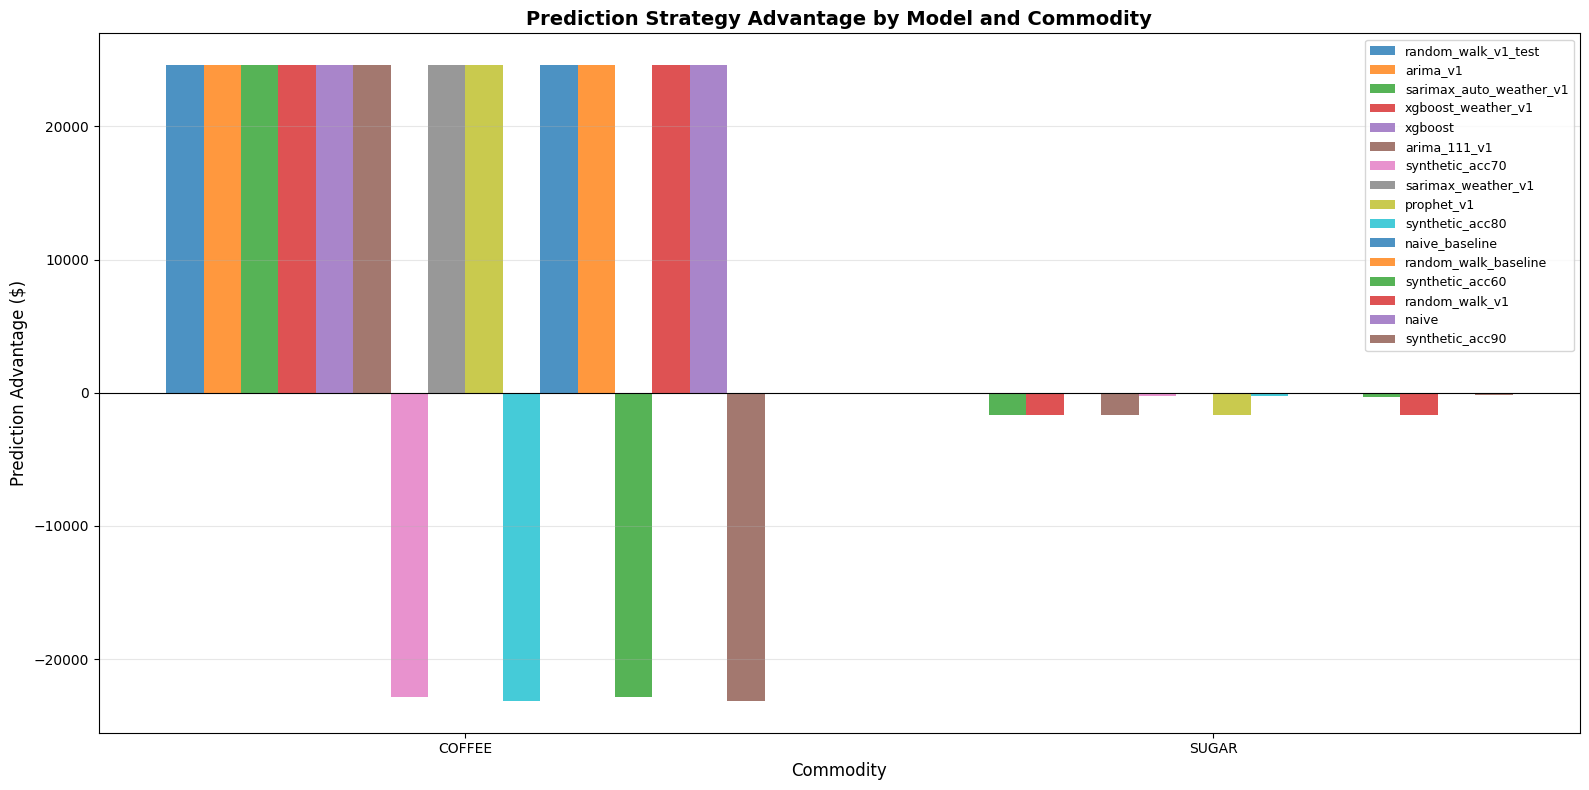

✓ Saved: /Volumes/commodity/trading_agent/files/cross_model_commodity_earnings.png


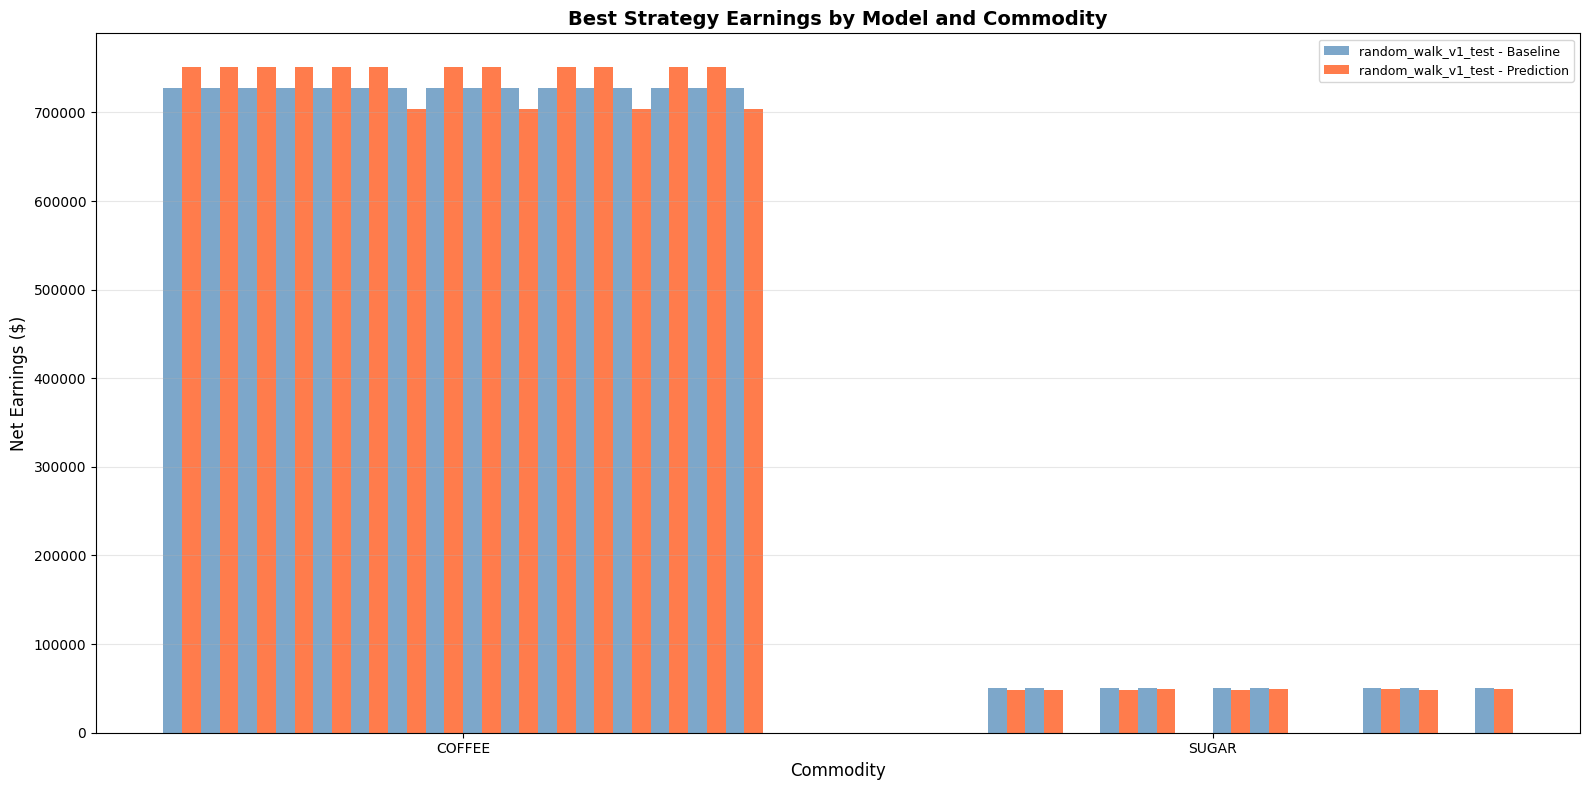


MULTI-COMMODITY/MULTI-MODEL COMPARATIVE ANALYSIS COMPLETE

Results saved to: /Volumes/commodity/trading_agent/files

Commodities analyzed: COFFEE, SUGAR
Total commodity-model combinations: 25
Strategies tested per combination: 9
  - 4 Baseline strategies
  - 5 Prediction-based strategies (3 enhanced + 2 A/B test)

✓ All analyses complete!

CROSS-MODEL AND CROSS-COMMODITY COMPARISON

✓ Saved detailed results: /Volumes/commodity/trading_agent/files/detailed_strategy_results.csv
   Total rows: 225 (all strategies)

📊 Summary by Commodity and Model:


Commodity,Model Version,Best Overall Strategy,Best Overall Earnings,Best Baseline Strategy,Best Baseline Earnings,Best Prediction Strategy,Best Prediction Earnings,Prediction Advantage ($),Prediction Advantage (%)
COFFEE,random_walk_v1_test,Expected Value,751640.636307348,Equal Batches,727036.9806840442,Expected Value,751640.636307348,24603.655623303843,3.384099609369953
COFFEE,arima_v1,Expected Value,751640.636307348,Equal Batches,727036.9806840442,Expected Value,751640.636307348,24603.655623303843,3.384099609369953
COFFEE,sarimax_auto_weather_v1,Expected Value,751640.636307348,Equal Batches,727036.9806840442,Expected Value,751640.636307348,24603.655623303843,3.384099609369953
COFFEE,xgboost_weather_v1,Expected Value,751640.636307348,Equal Batches,727036.9806840442,Expected Value,751640.636307348,24603.655623303843,3.384099609369953
COFFEE,xgboost,Expected Value,751640.636307348,Equal Batches,727036.9806840442,Expected Value,751640.636307348,24603.655623303843,3.384099609369953
COFFEE,arima_111_v1,Expected Value,751640.636307348,Equal Batches,727036.9806840442,Expected Value,751640.636307348,24603.655623303843,3.384099609369953
COFFEE,synthetic_acc70,Equal Batches,727036.9806840442,Equal Batches,727036.9806840442,Moving Average Predictive,704178.3521400508,-22858.62854399334,-3.144080583423204
COFFEE,sarimax_weather_v1,Expected Value,751640.636307348,Equal Batches,727036.9806840442,Expected Value,751640.636307348,24603.655623303843,3.384099609369953
COFFEE,prophet_v1,Expected Value,751640.636307348,Equal Batches,727036.9806840442,Expected Value,751640.636307348,24603.655623303843,3.384099609369953
COFFEE,synthetic_acc80,Equal Batches,727036.9806840442,Equal Batches,727036.9806840442,Moving Average Predictive,703890.0359773358,-23146.944706708426,-3.1837369104567776



✓ Saved summary: /Volumes/commodity/trading_agent/files/cross_model_commodity_summary.csv

KEY FINDINGS

💡 Best commodity/model for prediction-based strategies:
   COFFEE - random_walk_v1_test
   Advantage: $24,603.66
   (3.4% improvement)

Generating cross-model/commodity comparison charts...
✓ Saved: /Volumes/commodity/trading_agent/files/cross_model_commodity_advantage.png


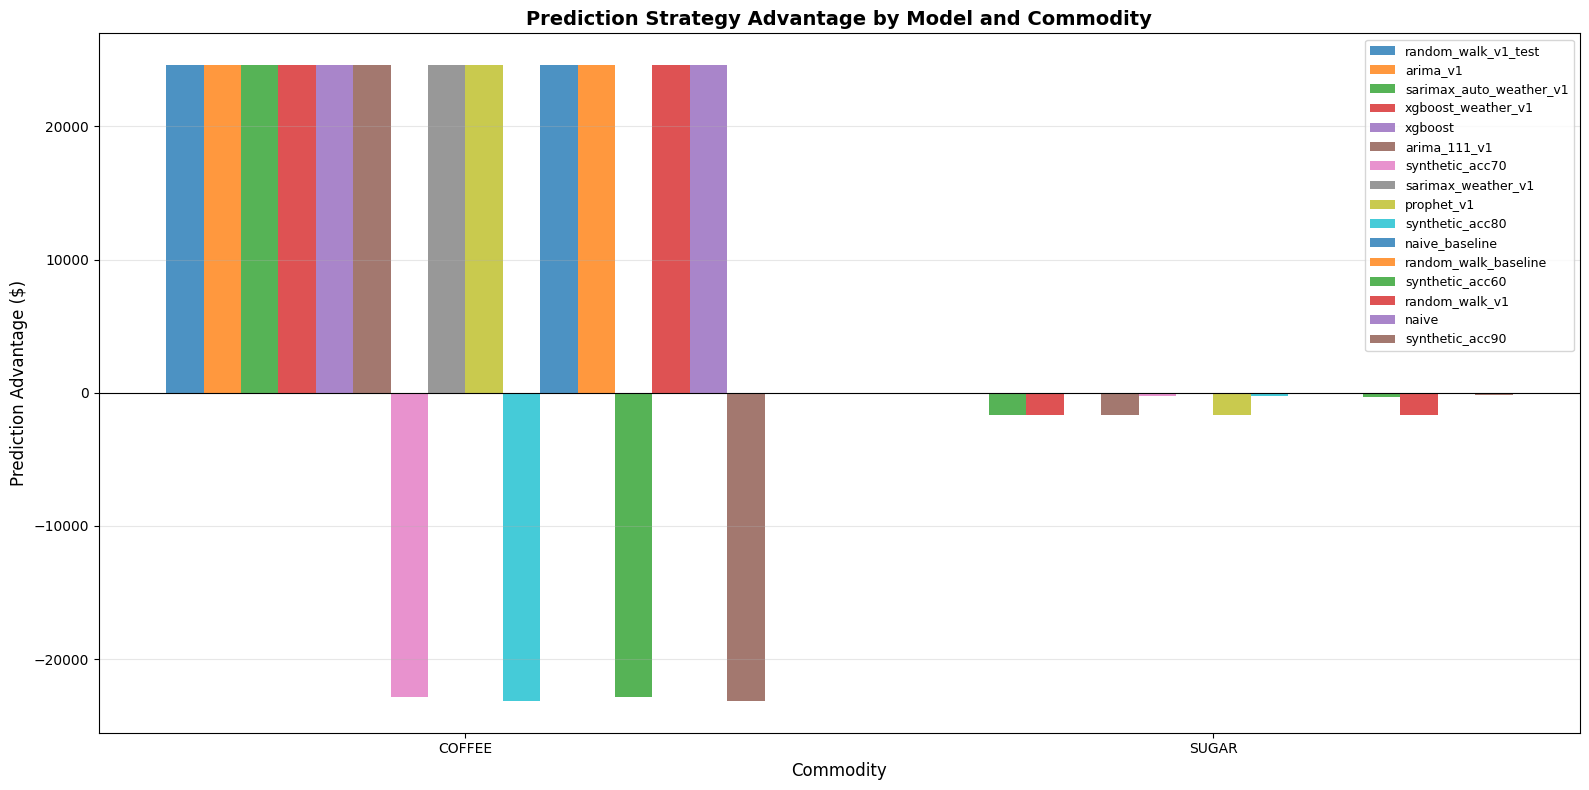

✓ Saved: /Volumes/commodity/trading_agent/files/cross_model_commodity_earnings.png


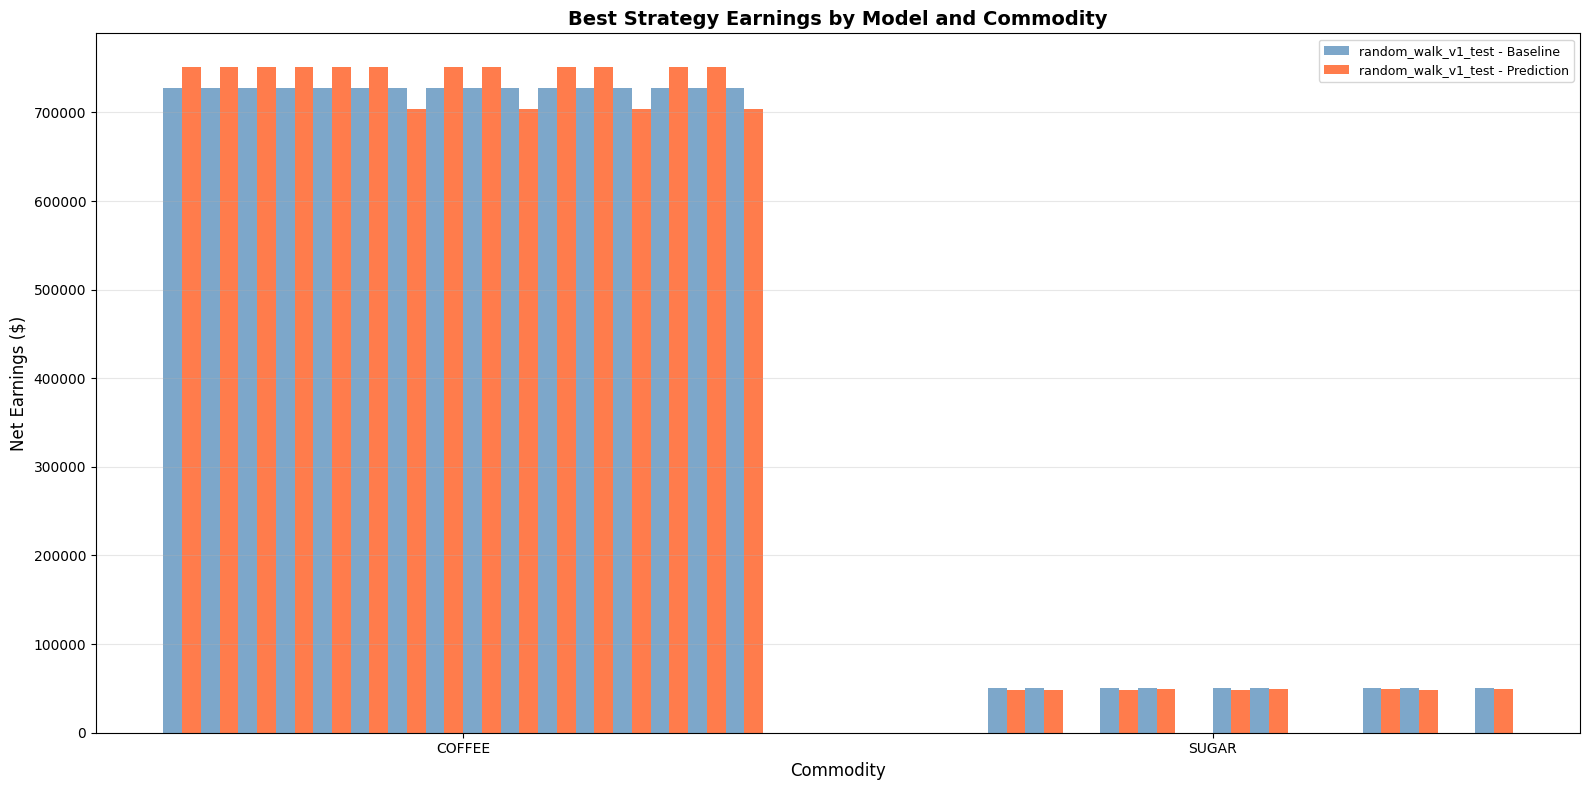


MULTI-COMMODITY/MULTI-MODEL COMPARATIVE ANALYSIS COMPLETE

Results saved to: /Volumes/commodity/trading_agent/files

Commodities analyzed: COFFEE, SUGAR
Total commodity-model combinations: 25
Strategies tested per combination: 9
  - 4 Baseline strategies
  - 5 Prediction-based strategies (3 enhanced + 2 A/B test)

✓ All analyses complete!


In [0]:
# MAGIC %md
# MAGIC ## Cross-Model and Cross-Commodity Comparison

# COMMAND ----------



print("\n" + "=" * 80)
print("CROSS-MODEL AND CROSS-COMMODITY COMPARISON")
print("=" * 80)

# Create detailed results table (all strategies)
detailed_results = []
for commodity_name, model_data in all_commodity_results.items():
    for model_version, results in model_data.items():
        results_df = results['results_df'].copy()
        results_df['Commodity'] = commodity_name.upper()
        results_df['Model Version'] = model_version
        detailed_results.append(results_df)

detailed_df = pd.concat(detailed_results, ignore_index=True)
detailed_df = detailed_df.sort_values(['Commodity', 'Model Version', 'net_earnings'], 
                                       ascending=[True, True, False])

# Save detailed results
detailed_path = f"{VOLUME_PATH}/detailed_strategy_results.csv"
detailed_df.to_csv(detailed_path, index=False)
print(f"\n✓ Saved detailed results: {detailed_path}")
print(f"   Total rows: {len(detailed_df)} (all strategies)")

# Create summary comparison (best strategies only - for charts)
comparison_data = []
for commodity_name, model_data in all_commodity_results.items():
    for model_version, results in model_data.items():
        comparison_data.append({
            'Commodity': commodity_name.upper(),
            'Model Version': model_version,
            'Best Overall Strategy': results['best_overall']['strategy'],
            'Best Overall Earnings': results['best_overall']['net_earnings'],
            'Best Baseline Strategy': results['best_baseline']['strategy'],
            'Best Baseline Earnings': results['best_baseline']['net_earnings'],
            'Best Prediction Strategy': results['best_prediction']['strategy'],
            'Best Prediction Earnings': results['best_prediction']['net_earnings'],
            'Prediction Advantage ($)': results['earnings_diff'],
            'Prediction Advantage (%)': results['pct_diff']
        })

comparison_df = pd.DataFrame(comparison_data)

print("\n📊 Summary by Commodity and Model:")
display(comparison_df)

# Save summary comparison
comparison_path = f"{VOLUME_PATH}/cross_model_commodity_summary.csv"
comparison_df.to_csv(comparison_path, index=False)
print(f"\n✓ Saved summary: {comparison_path}")

# Determine which commodity/model combination benefits most from predictions
best_combo = comparison_df.loc[comparison_df['Prediction Advantage ($)'].idxmax()]

print("\n" + "=" * 80)
print("KEY FINDINGS")
print("=" * 80)
print(f"\n💡 Best commodity/model for prediction-based strategies:")
print(f"   {best_combo['Commodity']} - {best_combo['Model Version']}")
print(f"   Advantage: ${best_combo['Prediction Advantage ($)']:,.2f}")
print(f"   ({best_combo['Prediction Advantage (%)']:.1f}% improvement)")

# COMMAND ----------

# MAGIC %md
# MAGIC ## Generate Cross-Model/Commodity Visualizations

# COMMAND ----------

print("\nGenerating cross-model/commodity comparison charts...")

# Separate synthetic and real models for visualization
synthetic_df = comparison_df[comparison_df['Model Version'].str.startswith('synthetic_')]
real_df = comparison_df[~comparison_df['Model Version'].str.startswith('synthetic_')]

# Chart 1: Prediction Advantage by Model and Commodity
fig, ax = plt.subplots(figsize=(16, 8))

commodities = comparison_df['Commodity'].unique()
models = comparison_df['Model Version'].unique()

x = np.arange(len(commodities))
width = 0.8 / len(models)

for i, model in enumerate(models):
    model_data = comparison_df[comparison_df['Model Version'] == model]
    advantages = [model_data[model_data['Commodity'] == c]['Prediction Advantage ($)'].values[0] 
                  if len(model_data[model_data['Commodity'] == c]) > 0 else 0
                  for c in commodities]
    
    ax.bar(x + i * width, advantages, width, label=model, alpha=0.8)

ax.set_xlabel('Commodity', fontsize=12)
ax.set_ylabel('Prediction Advantage ($)', fontsize=12)
ax.set_title('Prediction Strategy Advantage by Model and Commodity', fontsize=14, fontweight='bold')
ax.set_xticks(x + width * (len(models) - 1) / 2)
ax.set_xticklabels(commodities)
ax.legend(loc='best', fontsize=9)
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)

plt.tight_layout()
advantage_path = f"{VOLUME_PATH}/cross_model_commodity_advantage.png"
plt.savefig(advantage_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved: {advantage_path}")
plt.show()
plt.close()

# Chart 2: Best Strategy Earnings by Model and Commodity
fig, ax = plt.subplots(figsize=(16, 8))

for i, model in enumerate(models):
    model_data = comparison_df[comparison_df['Model Version'] == model]
    baseline_earnings = [model_data[model_data['Commodity'] == c]['Best Baseline Earnings'].values[0]
                         if len(model_data[model_data['Commodity'] == c]) > 0 else 0
                         for c in commodities]
    prediction_earnings = [model_data[model_data['Commodity'] == c]['Best Prediction Earnings'].values[0]
                          if len(model_data[model_data['Commodity'] == c]) > 0 else 0
                          for c in commodities]
    
    x_offset = x + i * width
    ax.bar(x_offset - width/4, baseline_earnings, width/2, 
           label=f'{model} - Baseline' if i == 0 else '', 
           color='steelblue', alpha=0.7)
    ax.bar(x_offset + width/4, prediction_earnings, width/2, 
           label=f'{model} - Prediction' if i == 0 else '', 
           color='orangered', alpha=0.7)

ax.set_xlabel('Commodity', fontsize=12)
ax.set_ylabel('Net Earnings ($)', fontsize=12)
ax.set_title('Best Strategy Earnings by Model and Commodity', fontsize=14, fontweight='bold')
ax.set_xticks(x + width * (len(models) - 1) / 2)
ax.set_xticklabels(commodities)
ax.legend(loc='best', fontsize=9)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
earnings_path = f"{VOLUME_PATH}/cross_model_commodity_earnings.png"
plt.savefig(earnings_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved: {earnings_path}")
plt.show()
plt.close()

# COMMAND ----------

print("\n" + "=" * 80)
print("MULTI-COMMODITY/MULTI-MODEL COMPARATIVE ANALYSIS COMPLETE")
print("=" * 80)
print(f"\nResults saved to: {VOLUME_PATH}")
print(f"\nCommodities analyzed: {', '.join([c.upper() for c in COMMODITY_CONFIGS.keys()])}")
print(f"Total commodity-model combinations: {len(comparison_df)}")
print(f"Strategies tested per combination: {len(all_strategies)}")
print(f"  - 4 Baseline strategies")
print(f"  - 5 Prediction-based strategies (3 enhanced + 2 A/B test)")
print(f"\n✓ All analyses complete!")# MAGIC %md
# MAGIC ## Cross-Model and Cross-Commodity Comparison

# COMMAND ----------



print("\n" + "=" * 80)
print("CROSS-MODEL AND CROSS-COMMODITY COMPARISON")
print("=" * 80)

# Create detailed results table (all strategies)
detailed_results = []
for commodity_name, model_data in all_commodity_results.items():
    for model_version, results in model_data.items():
        results_df = results['results_df'].copy()
        results_df['Commodity'] = commodity_name.upper()
        results_df['Model Version'] = model_version
        detailed_results.append(results_df)

detailed_df = pd.concat(detailed_results, ignore_index=True)
detailed_df = detailed_df.sort_values(['Commodity', 'Model Version', 'net_earnings'], 
                                       ascending=[True, True, False])

# Save detailed results
detailed_path = f"{VOLUME_PATH}/detailed_strategy_results.csv"
detailed_df.to_csv(detailed_path, index=False)
print(f"\n✓ Saved detailed results: {detailed_path}")
print(f"   Total rows: {len(detailed_df)} (all strategies)")

# Create summary comparison (best strategies only - for charts)
comparison_data = []
for commodity_name, model_data in all_commodity_results.items():
    for model_version, results in model_data.items():
        comparison_data.append({
            'Commodity': commodity_name.upper(),
            'Model Version': model_version,
            'Best Overall Strategy': results['best_overall']['strategy'],
            'Best Overall Earnings': results['best_overall']['net_earnings'],
            'Best Baseline Strategy': results['best_baseline']['strategy'],
            'Best Baseline Earnings': results['best_baseline']['net_earnings'],
            'Best Prediction Strategy': results['best_prediction']['strategy'],
            'Best Prediction Earnings': results['best_prediction']['net_earnings'],
            'Prediction Advantage ($)': results['earnings_diff'],
            'Prediction Advantage (%)': results['pct_diff']
        })

comparison_df = pd.DataFrame(comparison_data)

print("\n📊 Summary by Commodity and Model:")
display(comparison_df)

# Save summary comparison
comparison_path = f"{VOLUME_PATH}/cross_model_commodity_summary.csv"
comparison_df.to_csv(comparison_path, index=False)
print(f"\n✓ Saved summary: {comparison_path}")

# Determine which commodity/model combination benefits most from predictions
best_combo = comparison_df.loc[comparison_df['Prediction Advantage ($)'].idxmax()]

print("\n" + "=" * 80)
print("KEY FINDINGS")
print("=" * 80)
print(f"\n💡 Best commodity/model for prediction-based strategies:")
print(f"   {best_combo['Commodity']} - {best_combo['Model Version']}")
print(f"   Advantage: ${best_combo['Prediction Advantage ($)']:,.2f}")
print(f"   ({best_combo['Prediction Advantage (%)']:.1f}% improvement)")

# COMMAND ----------

# MAGIC %md
# MAGIC ## Generate Cross-Model/Commodity Visualizations

# COMMAND ----------

print("\nGenerating cross-model/commodity comparison charts...")

# Separate synthetic and real models for visualization
synthetic_df = comparison_df[comparison_df['Model Version'].str.startswith('synthetic_')]
real_df = comparison_df[~comparison_df['Model Version'].str.startswith('synthetic_')]

# Chart 1: Prediction Advantage by Model and Commodity
fig, ax = plt.subplots(figsize=(16, 8))

commodities = comparison_df['Commodity'].unique()
models = comparison_df['Model Version'].unique()

x = np.arange(len(commodities))
width = 0.8 / len(models)

for i, model in enumerate(models):
    model_data = comparison_df[comparison_df['Model Version'] == model]
    advantages = [model_data[model_data['Commodity'] == c]['Prediction Advantage ($)'].values[0] 
                  if len(model_data[model_data['Commodity'] == c]) > 0 else 0
                  for c in commodities]
    
    ax.bar(x + i * width, advantages, width, label=model, alpha=0.8)

ax.set_xlabel('Commodity', fontsize=12)
ax.set_ylabel('Prediction Advantage ($)', fontsize=12)
ax.set_title('Prediction Strategy Advantage by Model and Commodity', fontsize=14, fontweight='bold')
ax.set_xticks(x + width * (len(models) - 1) / 2)
ax.set_xticklabels(commodities)
ax.legend(loc='best', fontsize=9)
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)

plt.tight_layout()
advantage_path = f"{VOLUME_PATH}/cross_model_commodity_advantage.png"
plt.savefig(advantage_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved: {advantage_path}")
plt.show()
plt.close()

# Chart 2: Best Strategy Earnings by Model and Commodity
fig, ax = plt.subplots(figsize=(16, 8))

for i, model in enumerate(models):
    model_data = comparison_df[comparison_df['Model Version'] == model]
    baseline_earnings = [model_data[model_data['Commodity'] == c]['Best Baseline Earnings'].values[0]
                         if len(model_data[model_data['Commodity'] == c]) > 0 else 0
                         for c in commodities]
    prediction_earnings = [model_data[model_data['Commodity'] == c]['Best Prediction Earnings'].values[0]
                          if len(model_data[model_data['Commodity'] == c]) > 0 else 0
                          for c in commodities]
    
    x_offset = x + i * width
    ax.bar(x_offset - width/4, baseline_earnings, width/2, 
           label=f'{model} - Baseline' if i == 0 else '', 
           color='steelblue', alpha=0.7)
    ax.bar(x_offset + width/4, prediction_earnings, width/2, 
           label=f'{model} - Prediction' if i == 0 else '', 
           color='orangered', alpha=0.7)

ax.set_xlabel('Commodity', fontsize=12)
ax.set_ylabel('Net Earnings ($)', fontsize=12)
ax.set_title('Best Strategy Earnings by Model and Commodity', fontsize=14, fontweight='bold')
ax.set_xticks(x + width * (len(models) - 1) / 2)
ax.set_xticklabels(commodities)
ax.legend(loc='best', fontsize=9)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
earnings_path = f"{VOLUME_PATH}/cross_model_commodity_earnings.png"
plt.savefig(earnings_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved: {earnings_path}")
plt.show()
plt.close()

# COMMAND ----------

print("\n" + "=" * 80)
print("MULTI-COMMODITY/MULTI-MODEL COMPARATIVE ANALYSIS COMPLETE")
print("=" * 80)
print(f"\nResults saved to: {VOLUME_PATH}")
print(f"\nCommodities analyzed: {', '.join([c.upper() for c in COMMODITY_CONFIGS.keys()])}")
print(f"Total commodity-model combinations: {len(comparison_df)}")
print(f"Strategies tested per combination: {len(all_strategies)}")
print(f"  - 4 Baseline strategies")
print(f"  - 5 Prediction-based strategies (3 enhanced + 2 A/B test)")
print(f"\n✓ All analyses complete!")